In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install numpy tensorflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
# License Plate Recognition with Batch Processing and OCR

# Imports and Initialization
import cv2
import numpy as np
import os
import easyocr
import imutils

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])

# Directory Setup
# Paths to the input and output folders
image_folder = "dataset_1"
output_folder_annotated = "annotated_result"
output_folder_unannotated = "unannotated_result"

# Create input folders if they don't exist
os.makedirs(image_folder, exist_ok=True)
os.makedirs(output_folder_annotated, exist_ok=True)
os.makedirs(output_folder_unannotated, exist_ok=True)

# Batch Size Definition
# Define batch size
batch_size = 100

# Image Processing Functions

def process_with_code1(img, gray, img_name):
    """
    Processes an image using the first method: bilateral filter, edge detection, and contour approximation.
    Extracts text from the detected license plate region and annotates the image.
    """
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break

    if location is not None:
        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [location], 0, 255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]
        result = reader.readtext(cropped_image)

        if result:
            text = result[0][-2]
            font = cv2.FONT_HERSHEY_SIMPLEX
            annotated_img = cv2.putText(img.copy(), text=text, org=(location[0][0][0], location[1][0][1]+60),
                              fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
            annotated_img = cv2.rectangle(annotated_img, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)
            output_path_annotated = os.path.join(output_folder_annotated, img_name)
            cv2.imwrite(output_path_annotated, annotated_img)
            output_path_unannotated = os.path.join(output_folder_unannotated, img_name)
            cv2.imwrite(output_path_unannotated, img)
            return True, text

    return False, ""

def process_with_code2(img, gray, img_name):
    """
    Processes an image using the second method: bilateral filter, adaptive thresholding, and contour approximation.
    Extracts text from the detected license plate region and annotates the image.
    """
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 2.0 < aspect_ratio < 5.0:
                location = approx
                break

    if location is not None:
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)
        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1:x2+1, y1:y2+1]
        result = reader.readtext(cropped_image)
        plate_text = ""
        for detection in result:
            plate_text += detection[1] + " "

        if plate_text.strip():
            img_with_box = img.copy()
            cv2.drawContours(img_with_box, [location], -1, (0, 255, 0), 2)
            x, y, w, h = cv2.boundingRect(location)
            cv2.putText(img_with_box, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            output_path_annotated = os.path.join(output_folder_annotated, img_name)
            cv2.imwrite(output_path_annotated, img_with_box)
            output_path_unannotated = os.path.join(output_folder_unannotated, img_name)
            cv2.imwrite(output_path_unannotated, img)
            return True, plate_text.strip()

    return False, ""

# Batch Processing and Results Collection

batch_images = []
results = []
for idx, image_name in enumerate(os.listdir(image_folder)):
    try:
        img_path = os.path.join(image_folder, image_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        batch_images.append((img, gray, image_name))

        if len(batch_images) == batch_size or idx == len(os.listdir(image_folder)) - 1:
            for img, gray, image_name in batch_images:
                detected, text = process_with_code1(img, gray, image_name)
                if not detected:
                    detected, text = process_with_code2(img, gray, image_name)

                if detected:
                    results.append(f"{image_name} detected: {text}")
                else:
                    results.append(f"{image_name} not detected")

            batch_images.clear()

    except Exception as e:
        print(f"Error processing {image_name}: {e}")

for result in results:
    print(result)

print("Processing complete.")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Users\Mathu Pugalendhi Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

1.jpg detected: KL 16 J 3636
10.jpg not detected
100.jpg not detected
101.jpg not detected
102.jpg detected: KL 43B 2344
103.jpg detected: MH2OcS 4946
104.jpg detected: (KLOIKLO KLOI
105.jpg detected: 8
106.jpg detected: MH ZOEE 7597
107.jpg not detected
108.jpg detected: LAp46es 4500
109.jpg not detected
11.jpg detected: KOBL7253
110.jpg detected: IND MA 02 AJ aLLl
111.jpg not detected
112.jpg detected: 0
113.jpg not detected
114.jpg detected: RJ 27 TC 0530
115.jpg not detected
116.jpg not detected
117.jpg detected: FKa03na8385
118.jpg not detected
119.jpg not detected
12.jpg detected: NHI4EP4660
120.jpg detected: TN07 BU5L27
121.jpg not detected
122.jpg detected: MH2ODJ0419
123.jpg detected: Ap314t5064
124.jpg detected: MHZOBY36 65
125.jpg not detected
126.jpg detected: KL
127.jpg detected: H
128.jpg detected: KL01CA2555
129.jpg detected: KL 12G753
13.jpg not detected
130.jpg not detected
131.jpg not detected
132.jpg detected: HR 26 CT 6702
133.jpg not detected
134.jpg not detected
1

In [9]:
import os
import shutil
import random

# Paths to the folders
input_folder = "unannotated_result"
train_folder = "train_folder"
val_folder = "val_folder"
test_folder = "test_folder"

# Create output folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get a list of all images in the input folder
all_images = os.listdir(input_folder)
random.shuffle(all_images)

# Calculate the number of images for validation and test sets
total_images = len(all_images)
val_test_size = total_images // 4  # 25% for validation, 25% for test, and 50% for training

# Split the images
val_images = all_images[:val_test_size]
test_images = all_images[val_test_size:val_test_size * 2]
train_images = all_images[val_test_size * 2:]

# Move the images to the respective folders
for img_name in train_images:
    shutil.move(os.path.join(input_folder, img_name), os.path.join(train_folder, img_name))

for img_name in val_images:
    shutil.move(os.path.join(input_folder, img_name), os.path.join(val_folder, img_name))

for img_name in test_images:
    shutil.move(os.path.join(input_folder, img_name), os.path.join(test_folder, img_name))

print("Folder split complete.")

Folder split complete.


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_from_folder(folder, target_size):
    """
    Loads and preprocesses images from a specified folder.

    Args:
        folder (str): Path to the folder containing images.
        target_size (tuple): Desired size to which each image will be resized (height, width).

    Returns:
        np.ndarray: Array of preprocessed images.
    """
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Define image dimensions
img_height, img_width = 150, 150

# Load and preprocess images
train_images = load_images_from_folder('train_folder', (img_height, img_width))
val_images = load_images_from_folder('val_folder', (img_height, img_width))
test_images = load_images_from_folder('test_folder', (img_height, img_width))

# Create dummy labels since this is a binary classification task without actual labels
num_train_images = train_images.shape[0]
num_val_images = val_images.shape[0]
num_test_images = test_images.shape[0]

train_labels = np.zeros((num_train_images, 1))  # Dummy labels for training set
val_labels = np.zeros((num_val_images, 1))  # Dummy labels for validation set
test_labels = np.zeros((num_test_images, 1))  # Dummy labels for test set

# Convert to TensorFlow datasets
def create_dataset(images, labels, batch_size):
    """
    Converts images and labels to a TensorFlow dataset.

    Args:
        images (np.ndarray): Array of image data.
        labels (np.ndarray): Array of labels.
        batch_size (int): Number of samples per batch.

    Returns:
        tf.data.Dataset: TensorFlow dataset object.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create TensorFlow datasets
batch_size = 32
train_ds = create_dataset(train_images, train_labels, batch_size)
val_ds = create_dataset(val_images, val_labels, batch_size)
test_ds = create_dataset(test_images, test_labels, batch_size)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def create_cnn_model(input_shape):
    """
    Creates and compiles a Convolutional Neural Network (CNN) model.

    Args:
        input_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')  # Single output node for binary classification
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define input shape based on image dimensions
input_shape = (img_height, img_width, 3)

# Create and compile the CNN model
model = create_cnn_model(input_shape)

# Train the model
def train_model(model, train_ds, val_ds, epochs):
    """
    Trains the CNN model on the training dataset and validates on the validation dataset.

    Args:
        model (tf.keras.Model): The CNN model to train.
        train_ds (tf.data.Dataset): TensorFlow dataset for training.
        val_ds (tf.data.Dataset): TensorFlow dataset for validation.
        epochs (int): Number of epochs to train the model.

    Returns:
        History: Training history object containing loss and accuracy metrics.
    """
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds
    )
    return history

# Set number of epochs
epochs = 20

# Train the CNN model
history = train_model(model, train_ds, val_ds, epochs)

# Evaluate the model
def evaluate_model(model, test_ds):
    """
    Evaluates the CNN model on the test dataset.

    Args:
        model (tf.keras.Model): The CNN model to evaluate.
        test_ds (tf.data.Dataset): TensorFlow dataset for testing.

    Returns:
        tuple: Test loss and accuracy.
    """
    test_loss, test_acc = model.evaluate(test_ds)
    return test_loss, test_acc

# Evaluate the CNN model
test_loss, test_acc = evaluate_model(model, test_ds)
print(f'Test accuracy: {test_acc}')


Epoch 1/20


c:\Users\Mathu Pugalendhi Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.9219 - loss: 0.2831 - val_accuracy: 1.0000 - val_loss: 3.1239e-19
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - accuracy: 1.0000 - loss: 1.4261e-20 - val_accuracy: 1.0000 - val_loss: 4.7955e-35
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step - accuracy: 1.0000 - loss: 4.8306e-38 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 1.0000 - loss: 0.

In [12]:
# Evaluate on training data
train_loss, train_acc = model.evaluate(train_ds)
print(f'Training accuracy: {train_acc}')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0000e+00

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Training accuracy: 1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.0


In [13]:
# Evaluate on training data
train_loss, train_acc = model.evaluate(train_ds)
print(f'Training accuracy: {train_acc}')

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')

# Evaluate on val data
val_loss, val_acc = model.evaluate(val_ds)
print(f'Val accuracy: {val_acc}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Training accuracy: 1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Val accuracy: 1.0


In [14]:
# Save the model
model.save('license_plate_recognition_model.h5')

In [15]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

# Load the trained model
model = load_model('license_plate_recognition_model.h5')

In [16]:
import cv2
import numpy as np
import easyocr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])

# Load the trained model
model = tf.keras.models.load_model('license_plate_recognition_model.h5')

# Paths to input folder and output file
input_folder = "train_folder"
output_file = "train_predictions.txt"

# Define image dimensions for the model
img_height, img_width = 150, 150

def load_and_preprocess_image(img_path, target_size):
    """
    Loads and preprocesses an image for model prediction.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired size to which the image will be resized (height, width).

    Returns:
        np.ndarray: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_image(model, img_array):
    """
    Predicts the class of an image using the trained model.

    Args:
        model (tf.keras.Model): The trained CNN model.
        img_array (np.ndarray): Preprocessed image array.

    Returns:
        np.ndarray: Model prediction.
    """
    prediction = model.predict(img_array)
    return prediction

def extract_text_from_image(image_path):
    """
    Extracts text from an image using EasyOCR.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Extracted text from the image.
    """
    result = reader.readtext(image_path)
    detected_text = " ".join([res[1] for res in result])
    return detected_text

def process_images(input_folder, output_file, model, img_height, img_width):
    """
    Processes images in the input folder, predicts using the model, extracts text, 
    and saves results to the output file.

    Args:
        input_folder (str): Path to the folder containing images.
        output_file (str): Path to the file where predictions will be saved.
        model (tf.keras.Model): The trained CNN model.
        img_height (int): Height of the input image for the model.
        img_width (int): Width of the input image for the model.

    Returns:
        None
    """
    with open(output_file, 'w') as f:
        for filename in os.listdir(input_folder):
            img_path = os.path.join(input_folder, filename)
            img_array = load_and_preprocess_image(img_path, (img_height, img_width))
            prediction = predict_image(model, img_array)
            detected_text = extract_text_from_image(img_path)
            f.write(f"{filename}: {detected_text}\n")
            print(f"{filename}: {detected_text}")

    print("Prediction complete.")

# Process the images and save predictions
process_images(input_folder, output_file, model, img_height, img_width)

c:\Users\Mathu Pugalendhi Rao\AppData\Local\Programs\Python\Python312\Lib\site-packages\easyocr\detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
102.jpg: KL 43B 2344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
104.jpg: RLOIKLOKLOI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
105.jpg: NHO IND "BL2586
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
108.jpg: 4P46es4500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
110.jpg: MA 02 AJ NFIELD 344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
114.jpg: Ddeeer RJ 27 TC 0530 CED CAADEKHO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
12.jpg: HHI4EP 4660 Aicanvale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
122.jpg: NH2ODJ0419_
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
126.jpg: KL 10 AW 2814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
128.jpg: KLC1CA2555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
136.jpg: Tafdido
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
138.jpg: N9BF2378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
140.jpg: Skooa Ddco MH : 20 FE 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
144.jpg: APAI DE 2832
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
148.jpg: Indian MH02 Ci2727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
149.jpg: FMH20EE 76

In [17]:
import cv2
import numpy as np
import easyocr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])

# Load the trained model
model = tf.keras.models.load_model('license_plate_recognition_model.h5')

# Paths to input folder and output file
input_folder = "test_folder"
output_file = "test_predictions.txt"

# Define image dimensions for the model
img_height, img_width = 150, 150

def load_and_preprocess_image(img_path, target_size):
    """
    Loads and preprocesses an image for model prediction.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired size to which the image will be resized (height, width).

    Returns:
        np.ndarray: Preprocessed image array.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_image(model, img_array):
    """
    Predicts the class of an image using the trained model.

    Args:
        model (tf.keras.Model): The trained CNN model.
        img_array (np.ndarray): Preprocessed image array.

    Returns:
        np.ndarray: Model prediction.
    """
    prediction = model.predict(img_array)
    return prediction

def extract_text_from_image(image_path):
    """
    Extracts text from an image using EasyOCR.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Extracted text from the image.
    """
    result = reader.readtext(image_path)
    detected_text = " ".join([res[1] for res in result])
    return detected_text

def process_images(input_folder, output_file, model, img_height, img_width):
    """
    Processes images in the input folder, predicts using the model, extracts text, 
    and saves results to the output file.

    Args:
        input_folder (str): Path to the folder containing images.
        output_file (str): Path to the file where predictions will be saved.
        model (tf.keras.Model): The trained CNN model.
        img_height (int): Height of the input image for the model.
        img_width (int): Width of the input image for the model.

    Returns:
        None
    """
    with open(output_file, 'w') as f:
        for filename in os.listdir(input_folder):
            img_path = os.path.join(input_folder, filename)
            img_array = load_and_preprocess_image(img_path, (img_height, img_width))
            prediction = predict_image(model, img_array)
            detected_text = extract_text_from_image(img_path)
            f.write(f"{filename}: {detected_text}\n")
            print(f"{filename}: {detected_text}")

    print("Prediction complete.")

# Process the images and save predictions
process_images(input_folder, output_file, model, img_height, img_width)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1.jpg: ZCAAP KL 16 J 3636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
103.jpg: Mh2OCS 4946 Moto Beam c mn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
106.jpg: MH Z0EE 7597
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
124.jpg: MH2OBY36 65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
129.jpg: GtI KL 12G7531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
132.jpg: HR 26 CT 6702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
146.jpg: BALENO KL 10 AV 6633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
152.jpg: HR 99 HA (TE"Py 4575 Haymarket SAC Publishing (India) Pv Ltd; 2011: All rights reserved: WV bautocaripr con
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157.jpg: Follow us LBRBiZ] KL13 AA 8340 8281 33 46 46 7012 71 70 83 Wdwarbiz_in
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
162.jpg: EAP16DP7065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
168.jpg: Ll KL 25 B 2001 Bozur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
170.jpg: HR 26 DA 2330|
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
183.jpg: Ad-4auto Ccom KLO7BF5OOO
1/1 ━━━━━━━━━━━━

In [18]:
import cv2
import numpy as np
import easyocr
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])

# Load the trained model
model = tf.keras.models.load_model('license_plate_recognition_model.h5')

# Paths to input folder and output file
input_folder = "val_folder"
output_file = "val_predictions.txt"

# Define image dimensions for the model
img_height, img_width = 150, 150

def load_and_preprocess_image(img_path, target_size):
    """
    Loads and preprocesses an image for model prediction.

    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Desired size to which the image will be resized (height, width).

    Returns:
        np.ndarray: Preprocessed image array suitable for model input.
    """
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return np.expand_dims(img_array, axis=0)

def predict_image(model, img_array):
    """
    Predicts the class of an image using the trained model.

    Args:
        model (tf.keras.Model): The trained CNN model.
        img_array (np.ndarray): Preprocessed image array.

    Returns:
        np.ndarray: Model prediction.
    """
    prediction = model.predict(img_array)
    return prediction

def extract_text_from_image(image_path):
    """
    Extracts text from an image using EasyOCR.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Extracted text from the image.
    """
    result = reader.readtext(image_path)
    detected_text = " ".join([res[1] for res in result])
    return detected_text

def process_images(input_folder, output_file, model, img_height, img_width):
    """
    Processes images in the input folder, predicts using the model, extracts text,
    and saves results to the output file.

    Args:
        input_folder (str): Path to the folder containing images.
        output_file (str): Path to the file where predictions will be saved.
        model (tf.keras.Model): The trained CNN model.
        img_height (int): Height of the input image for the model.
        img_width (int): Width of the input image for the model.

    Returns:
        None
    """
    with open(output_file, 'w') as f:
        for filename in os.listdir(input_folder):
            img_path = os.path.join(input_folder, filename)
            img_array = load_and_preprocess_image(img_path, (img_height, img_width))
            prediction = predict_image(model, img_array)
            detected_text = extract_text_from_image(img_path)
            f.write(f"{filename}: {detected_text}\n")
            print(f"{filename}: {detected_text}")

    print("Prediction complete.")

# Process the images and save predictions
process_images(input_folder, output_file, model, img_height, img_width)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
11.jpg: KOBL25 KLT8 IND [7253
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
112.jpg: IND TSO8ER1643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
117.jpg: Kanrt2 Ka03nA8385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
120.jpg: IN 07 BU5427 Team-Bhe Emn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
123.jpg: AP3144T5064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
127.jpg: Liotaulortn MH 14 ICE 460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
135.jpg: Ac 0183L
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
137.jpg: GTI KL GN 5344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
139.jpg: EON APSCG 6320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
141.jpg: 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
145.jpg: MI 2OBN 3525 MotoBeamczm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
151.jpg: GT HH 14DT 8831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
153.jpg: IND DL49 AK49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
16.jpg: KA 29 Z 999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
173.jpg: AP31BL8656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
179.jpg: IND As M 104

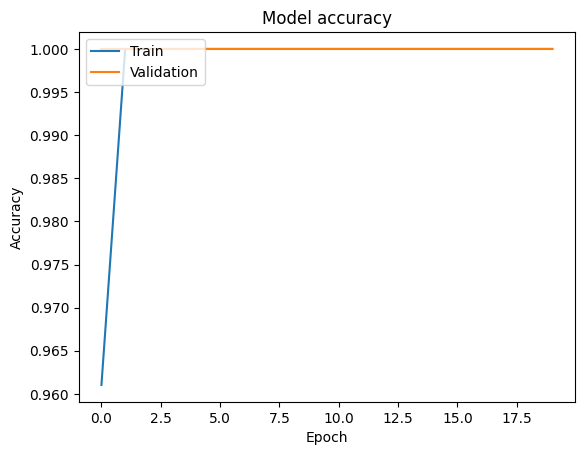

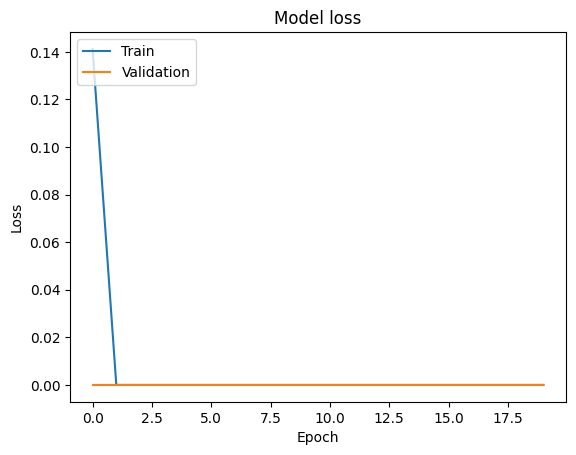

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
# Path to a specific image file
img_path = r"val_folder\4.jpg"

# Load and preprocess the image
new_image = load_and_preprocess_image(img_path, (img_height, img_width))

# Predict
predictions = model.predict(new_image)

print(f'Prediction: {predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction: [[0.]]


In [21]:
# Load new images
new_images = load_images_from_folder('val_folder', (img_height, img_width))

# Predict
predictions = model.predict(new_images)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


In [22]:
def load_and_predict_text_from_folder(folder, target_size):
    extracted_texts = []

    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Preprocess the image as needed
        img = cv2.resize(img, target_size)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Normalize the image

        # Predict using the model
        prediction = model.predict(img)

        # Convert the prediction to text (assuming binary classification)
        # You might need to customize this based on your specific use case
        text = "Detected" if prediction[0] > 0.5 else "Not Detected"

        extracted_texts.append((filename, text))

    return extracted_texts

In [23]:
folder_path = 'val_folder'  # Specify your input folder
target_size = (150, 150)  # Use the same size used during training

extracted_texts = load_and_predict_text_from_folder(folder_path, target_size)

# Print the extracted text
for filename, text in extracted_texts:
    print(f"{filename}: {text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [24]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('license_plate_recognition_model.h5')

# Check the input shape expected by the model
print(model.input_shape)


(None, 150, 150, 3)


In [25]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('license_plate_recognition_model.h5')

# Print the model summary to check input and output shapes of all layers
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,179 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)